In [1]:
import numpy as np 
import pandas as pd 
from ase import Atoms
from ase import Atom
from ase.io import read
from ase.io import iread
from ase.io import write
from ase.io.trajectory import TrajectoryReader
import os
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [47]:


def binned_distance(dist, bins):
    binned = np.zeros(len(bins)-1)
    binned += np.histogram(dist, bins)[0]
    return binned 

In [48]:
basepath_verlet = '../../smdick/mbpol/pureverlet_128_10_0.5'
basepath_nose = '../../smdick/mbpol/md_128_10_0.5'

In [49]:
def load_files(basepath, start = 100, dt = 1, force_recalc = False):
    logfile = pd.read_csv(basepath + '.log', delim_whitespace=True, index_col = 0)
    traj_path = basepath + '.traj'
    
    try:
        if force_recalc: raise FileNotFoundError
        bins_df = pd.read_csv(basepath + '.bins', index_col=0)
    except FileNotFoundError:
        print('Data not binned. Binning now...')
        end =  len(logfile)
        dr = 0.05
        bins = np.arange(2,8,dr)

        r_oo = np.zeros(len(bins) - 1)

        for i in range(start,end,dt):
#             if (int(i*dt/(end-start)*100)%10 == 0): print(int(i*dt/(end-start)*100))
            traj = read(traj_path, index = i)
            r_oo += binned_distance(traj.get_all_distances(mic = True)[::3,::3][np.triu_indices(128,1)], bins)


        g_avg = .5*128*(127)/(15.646**3)
        n_obs = len(range(start,end,dt))

        norm1 = bins[:-1]**2 * g_avg * n_obs * 4 * np.pi * dr
        # norm2 = bins[1:]**2 * g_avg * n_obs * 4 * np.pi * dr

        plot(bins[:-1],r_oo/norm1, ls ='--', marker = '.')
        # plot(bins[1:], r_oo/norm2)
        grid()

        pd.DataFrame({'bins': bins[:-1],'rho': r_oo/norm1}).to_csv(basepath + '.bins', index = None)
        bins_df = pd.read_csv(basepath + '.bins', index_col=0)
        
    return [logfile, bins_df]

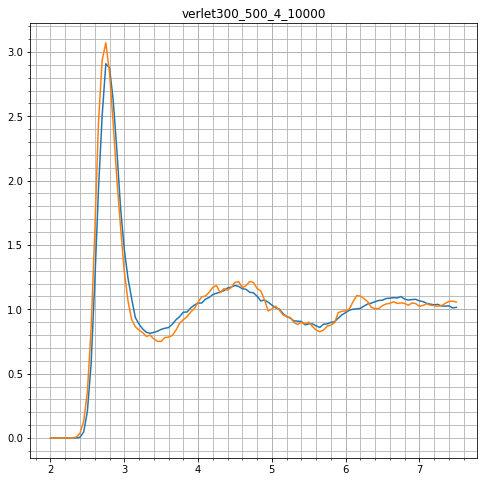

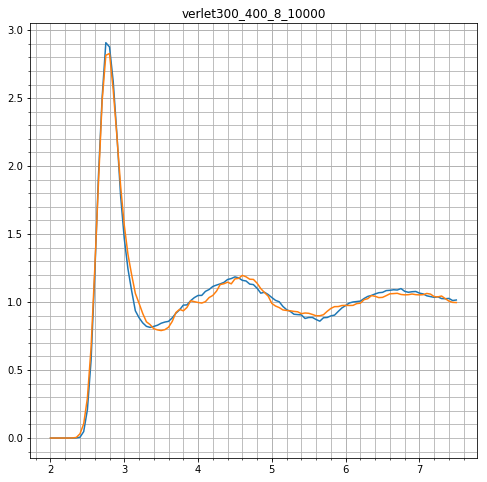

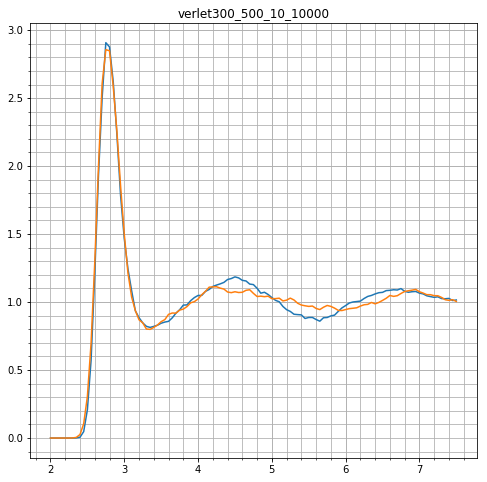

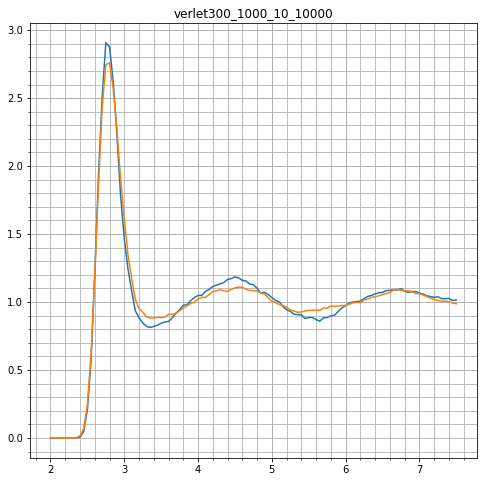

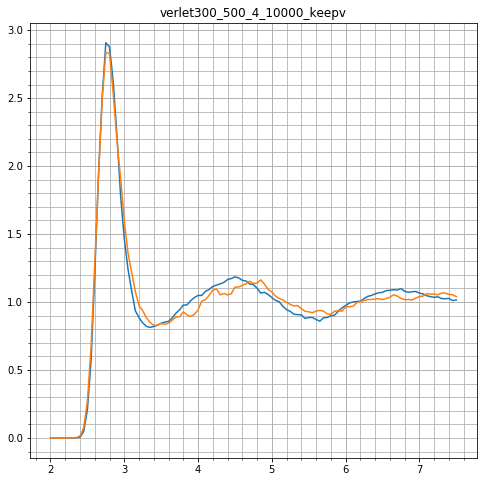

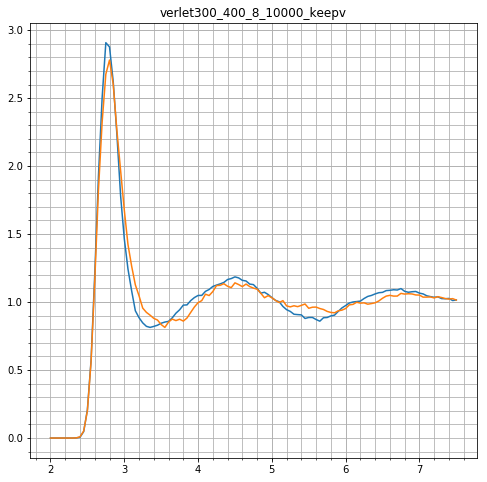

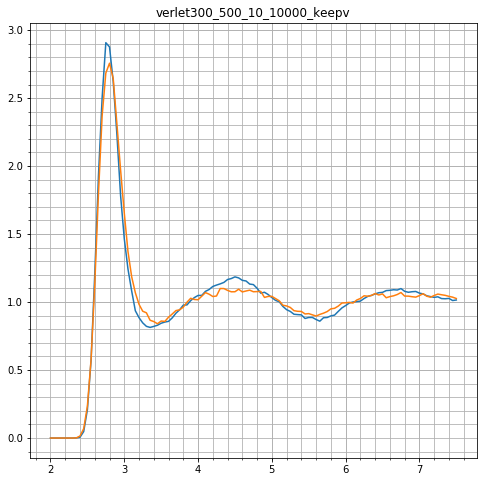

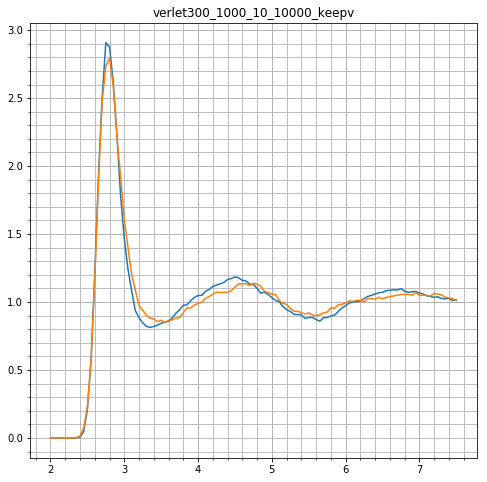

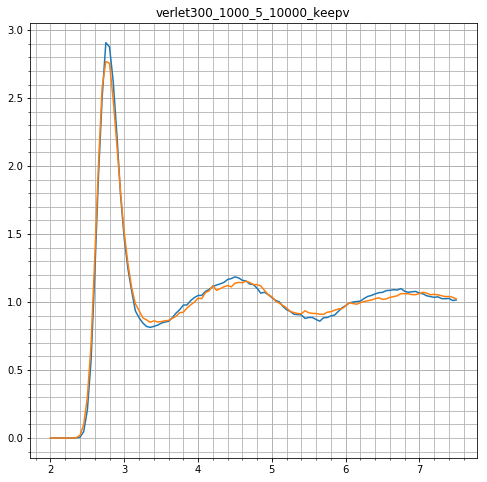

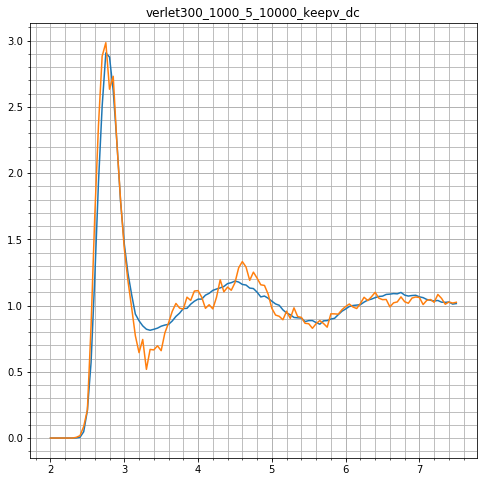

In [154]:
for root, dirs, filenames in os.walk(indir):
    for f in filenames:
        if 'log' in f and 'verlet' in f:
            basepath = root + f[:-4]
            _, bins_verlet = load_files(indir + basepath)
            figsize(4,4)
            figure()
            plot(bins_nose.loc[:7.5])
            plot(bins_verlet.loc[:7.5])
            grid(b=True, which = 'both')
            minorticks_on()
            title(basepath)

Data not binned. Binning now...


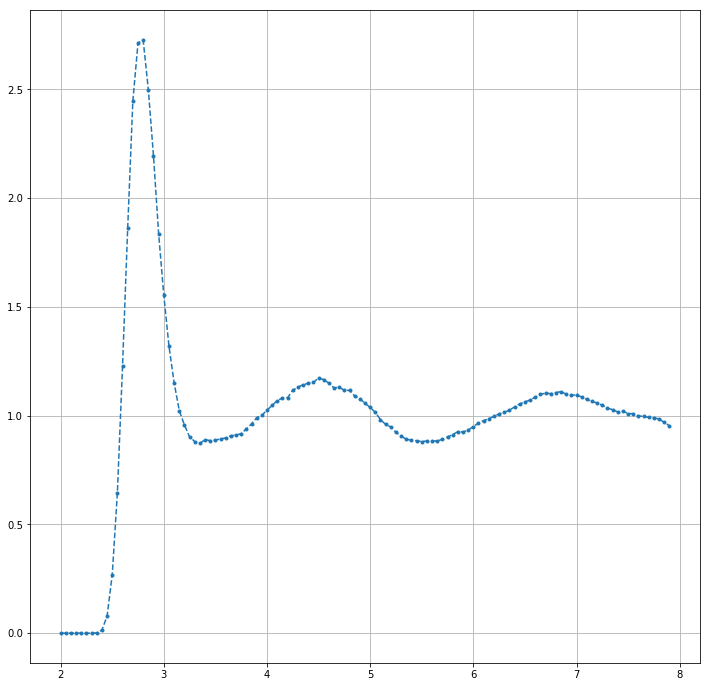

In [70]:
_, bins_nose = load_files(basepath_nose, start = 4000, dt = 20, force_recalc= False)
_, bins_verlet_mc = load_files('/gpfs/home/smdick/smdick/mbpol/verlet300_1000_5_100000_keepv',50, 2, False)
# _, bins_ttm3f = load_files('/gpfs/home/smdick/smdick/mbpol/ttm3f_nose',400,1,False)
_, bins_verlet = load_files(basepath_verlet, 4000, 10, False)

In [71]:
errors = pd.read_csv(basepath_nose + '.errors', index_col =0)
errors.columns = ['rho']

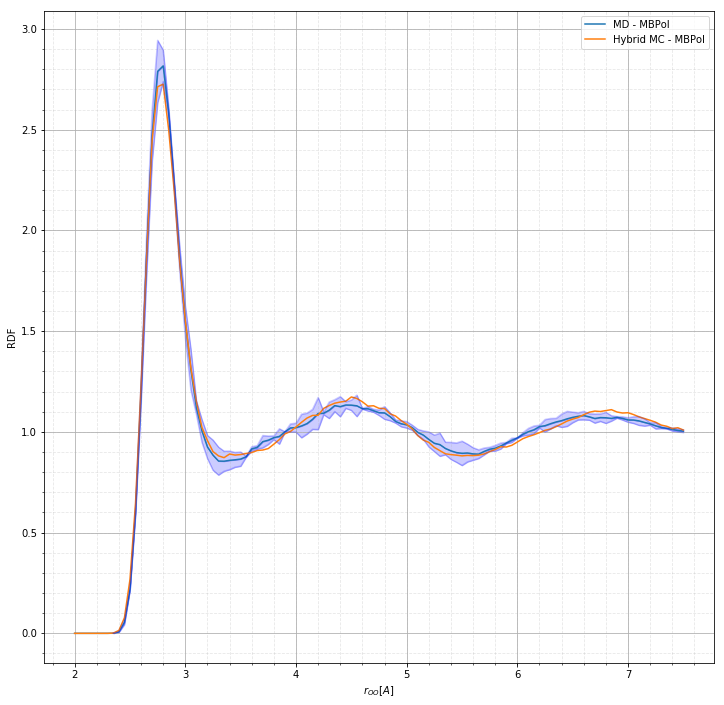

In [72]:
figsize(12,12)
plot(bins_nose.loc[:7.5], marker = '', ms = 4, label = 'MD - MBPol')
# plot(bins_nose2.loc[:7.5], ls = '--',marker ='.', ms =  4)
# plot(bins_ttm3f.loc[:7.5], ls = '-',marker ='', ms =  4, alpha = .7, label = 'MD - TTM3-F')
plot(bins_verlet_mc.loc[:7.5],lw = 1.5, ls = '-',marker ='', ms =  4, label = 'Hybrid MC - MBPol')
fill_between(bins_nose.loc[:7.5].index,bins_nose.loc[:7.5]['rho'], (bins_nose.loc[:7.5] + 2*errors.loc[:7.5])['rho'],
            color = 'blue', alpha = 0.2 )
fill_between(bins_nose.loc[:7.5].index,bins_nose.loc[:7.5]['rho'], (bins_nose.loc[:7.5] - 2*errors.loc[:7.5])['rho'],
            color = 'blue', alpha = 0.2 )

plot(bins_nose.loc[:7.5] - 2*errors.loc[:7.5],
            color = 'blue', alpha = 0.2 )
plot(bins_nose.loc[:7.5] + 2*errors.loc[:7.5],
            color = 'blue', alpha = 0.2 )


# plot(bins_verlet.loc[:7.5], ls = '-',marker ='.', ms =  4)
# plot(verlet_save.loc[:7.5])
minorticks_on()
grid(which = 'major')
grid(which = 'minor', ls ='--', alpha = .3)
xlabel('$r_{OO}[A]$')
ylabel('RDF')
legend()
savefig('RDF.pdf')

In [206]:
def mc_sampling(energies, timestep=0.001, temperature = 0.02586):
    
    probs = np.random.rand(len(energies))
    accepted = [0]
    last_accepted = [0]
    
    t0 = energies.index[0]
    tf = energies.index[-1]
    realstep = int(len(energies)/((tf-t0)/timestep))
    energies = np.array(energies)[::realstep]
    
    j = 0
    k = 1
    
    for i, e in enumerate(energies):
        
        if i == 0: continue
            
        try:
            j = last_accepted[-k]
        except IndexError:
            j = last_accepted[0]
        
        de = e - energies[j]
        
        if de < 0:
            accepted.append(i)
            if k > 1:
                last_accepted = last_accepted[:-k+1]
                
            last_accepted.append(i)
            k =1
        else:
            if probs[i] <= np.exp(-de/temperature):
                accepted.append(i)
                if k > 1:
                    last_accepted = last_accepted[:-k+1]
                last_accepted.append(i)
                k = 1
            else:
                k += 1 
                continue
#         if i < 50:
#             print(accepted)
#             print(last_accepted)
    return accepted           
            
        

In [207]:
md_df = pd.read_csv('./../../smdick/mbpol/md_128_10_0.5.log', delim_whitespace=True, index_col=0)

In [208]:
accepted = mc_sampling(md_df['Etot[eV]'].loc[4.0:])

In [210]:
len(accepted)/len(md_df.loc[4.0:])

0.0920008201282915

In [216]:
accepted = np.array(accepted) + 7999

In [217]:
traj_path = './../../smdick/mbpol/md_128_10_0.5.traj'

In [218]:

dt = 10
dr = 0.05
bins = np.arange(2,7.5,dr)

r_oo_mc = np.zeros(len(bins) - 1)

for i in accepted:
    traj = read(traj_path, index = i)
    r_oo_mc += binned_distance(traj.get_all_distances(mic = True)[::3,::3][np.triu_indices(128,1)], bins)

In [219]:

g_avg = .5*128*(127)/(15.646**3)
n_obs = len(accepted)

norm1 = bins[:-1]**2 * g_avg * n_obs * 4 * np.pi * dr

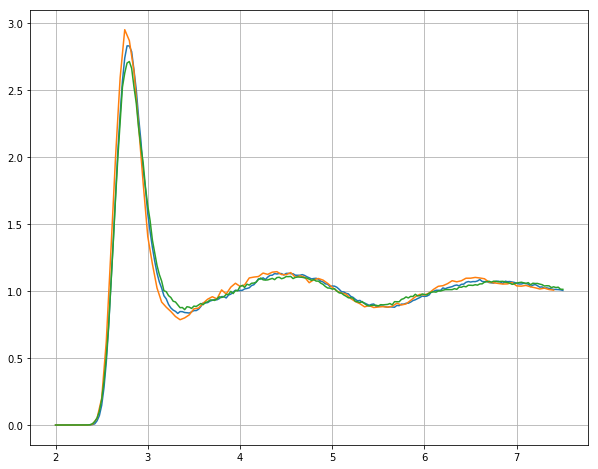

In [221]:
plot(bins_nose.loc[:7.5],marker = '', ms = 4)
plot(bins[:-1],r_oo_mc/norm1)
plot(bins_verlet_mc.loc[:7.5])
# plot(bins[:-1],r_oo/norm)
grid()

In [73]:
24*60*7

10080

In [75]:
353.539/60

5.892316666666667